In [3]:
def translate(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
    {
        "role": "system",
        "content": "You will be provided with a verb in Moroccan Darija language." +
        "Your task is to translate it into English and provide only its lemma as an output." + 
                    "The lemma of the translated verb should not contain 'to'."
    },
    {
        "role": "user", 
        "content":  f'{verb}' 
    }
            ], 
        temperature=0.1  
        )
    return completion.choices[0].message.content
df['transl'] = df['n1'].apply(translate)

print(df['transl'])

0              eat
1              buy
2            enter
3             exit
4       understand
           ...    
1027        arrive
1028        invite
1029            go
1030       scratch
1031        search
Name: transl, Length: 1032, dtype: object


In [5]:
from nltk.corpus import wordnet as wn


transl = df['transl']
eng = df['eng']
transl = [verb.replace(" ", "_") for verb in transl]
eng = [verb.replace(" ", "_") for verb in eng]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""
    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score
# Calculate and print the path similarity for each pair of verbs with similar index

def evaluate_pairs(threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((i+2, word1, word2, similarity, similarity >= threshold))
    return results
results = evaluate_pairs()
print(results)

[(2, 'eat', 'eat', 1.0, True), (3, 'buy', 'drink', 0.2, False), (4, 'enter', 'enter', 1.0, True), (5, 'exit', 'go_out', 1.0, True), (6, 'understand', 'understand', 1.0, True), (7, 'search', 'explain', 0.2, False), (8, 'read', 'learn', 1.0, True), (9, 'read', 'teach', 0.25, False), (10, 'listen', 'hear', 1.0, True), (11, 'see', 'see', 1.0, True), (12, 'drink', 'smell', 0.2, False), (13, 'sleep', 'taste', 0.25, False), (14, 'laugh', 'touch', 0.25, False), (15, 'walk', 'go', 0.5, True), (16, 'come', 'come', 1.0, True), (17, 'play', 'ascend', 0.3333333333333333, False), (18, 'descend', 'go_down', 1.0, True), (19, 'sleep', 'swim', 0.2, False), (20, 'eat', 'drown', 0.2, False), (21, 'eat', 'wear', 0.25, False), (22, 'Hello!_How_can_I_assist_you_today?', 'take_off', 0, False), (23, 'buy', 'buy', 1.0, True), (24, 'go', 'sell', 0.3333333333333333, False), (25, 'listen', 'bargain', 0.125, False), (26, 'write', 'write', 1.0, True), (27, 'hear', 'clean', 0.25, False), (28, 'hit', 'hit', 1.0, True)

Average similarity: 0.36%
Count of pairs in the interval 90-100%: 141


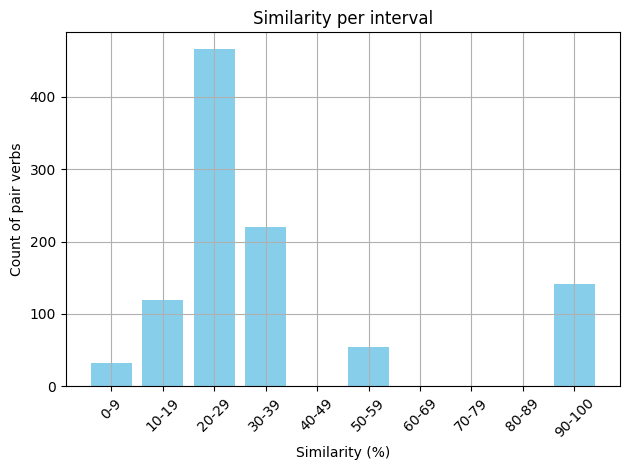

In [12]:
import matplotlib.pyplot as plt

similarities = [item[3] for item in results]

# Calculate the average similarity
average_similarity = sum(similarities) / len(similarities)

# Print the result
print(f'Average similarity: {average_similarity:.2f}%')


# Define intervals of 10%
intervals = [(i, i+10) for i in range(0, 90, 10)] + [(90, 101)]

# Count similarities in each interval
interval_counts = {interval: 0 for interval in intervals}
for sim in similarities:
    percentage = sim * 100  # Convert cosine similarity to percentage
    for interval in intervals:
        if interval[0] <= percentage < interval[1]:
            interval_counts[interval] += 1
            break



# Count pairs in the interval 90-100%
count_90_100 = interval_counts[(90, 101)]

# Print the count for the interval 90-100%
print(f'Count of pairs in the interval 90-100%: {count_90_100}')



# Prepare data for plotting
labels = [f'{interval[0]}-{interval[1]-1}' if interval[1] != 101 else '90-100' for interval in intervals]
counts = [interval_counts[interval] for interval in intervals]

# Plot bar chart
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Similarity (%)')
plt.ylabel('Count of pair verbs')
plt.title('Similarity per interval')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()